In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import time
#A continuación se importan laas librerias necesarias para el entrenamiento de la red 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import ConvLSTM2D
from keras.layers import Flatten
from keras.optimizers import SGD, Adam


Using TensorFlow backend.


(210721,)


Text(0.5, 1.0, 'Datos reales')

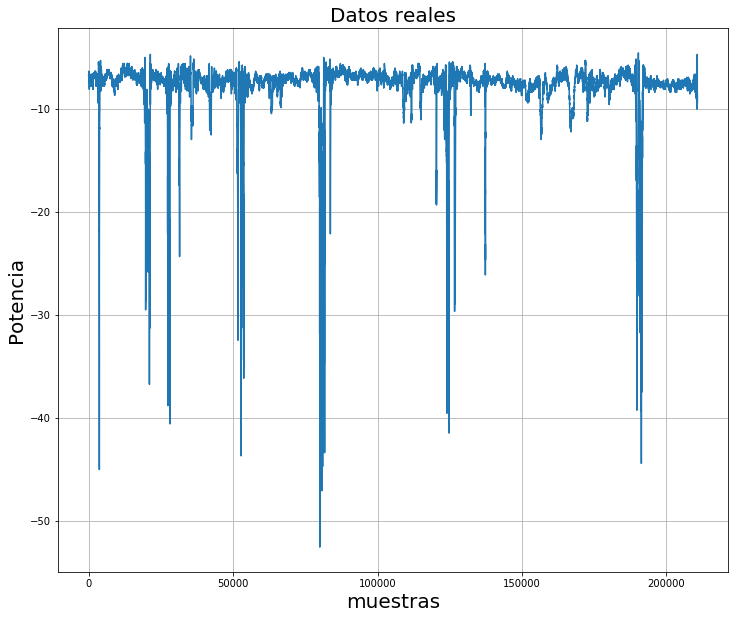

In [3]:
dataframe = pd.read_csv('/content/drive/My Drive/LSTM /Mediciones en csv/LTLOS CSV/potencia 2000-01-30 22_3A35_3A55 Antenna Horn Time 300[s] SwitchingBy 0 Horn 0 Omni 0 FIN_018.csv', header=None )
#llevar al dataframe a un arreglo de valores
dataset = dataframe.values
#dataset solo para la funcion senoidal
POT = dataset[0:len(dataset),1]
#POT = dataset
print(POT.shape)
plt.figure(figsize=[12,10])
plt.grid()
plt.plot(POT)
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.title("Datos reales", fontsize = 20)

# Nueva sección

In [4]:
#llevo la funcion a un arreglo de [lARGO DEL ARREGLO ,1] PARA ESCALAR LOS DATOS y que la red aprenda de mejor forma
POT2=POT.reshape(len(POT),1)
print(POT2.shape)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
POT2 = scaler.fit_transform(POT2)

(210721, 1)


In [5]:
# divido la funcion y1 en arreglos para entrenar y probar la red
train_size = int(len(POT2) * 0.8)
test_size = len(POT2) - train_size
train, test = POT2[0:train_size,:], POT2[train_size:len(POT2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

168576 42145
(168576, 1)
(42145, 1)


In [0]:
# convertir un arreglo de valores en una matrix
def create_dataset(POT2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(POT2)-look_back-1):
        a = POT2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(POT2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# reshape dentro X=t and Y=t+1
look_back = 128
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
#print(trainX[0])
#print(trainY[0])
#print(trainX[1])
#print(trainY[1])
#print(trainX[2])
#print(trainY[3])

(168447, 128)
(42016, 128)
(168447,)
(42016,)


In [8]:
# reshape a la entrada [samples, time steps, features] que es necesario para la red lstm
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(168447, 1, 128)
(42016, 1, 128)






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,701
Trainable params: 91,701
Non-trainable params: 0
_________________________________________________________________


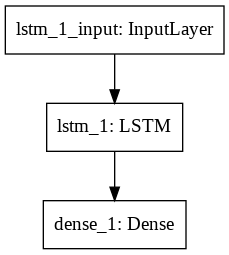

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100,input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.summary()
keras.utils.plot_model(model, 'my_first_model.png')

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
filepath="Checkpoint_mejores_pesos_señal_ltlos_S2_lstm.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_percentage_error', verbose=1, save_best_only=True, mode='min')
# simple early stopping
es = EarlyStopping(monitor='val_mean_absolute_percentage_error', mode='min', verbose=1, patience=5)

In [11]:
batch_size= 32 
epochs= 30
start = time.time()
History_ltlos2_lstm = model.fit(trainX, trainY,batch_size=batch_size, epochs= epochs, callbacks=[es, checkpoint] , validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 151602 samples, validate on 16845 samples
Epoch 1/30





151602/151602 [==============================] - 38s 252us/step - loss: 7.4152e-04 - mean_squared_error: 7.4152e-04 - mean_absolute_error: 0.0101 - mean_absolute_percentage_error: 1448.9666 - val_loss: 8.5782e-05 - val_mean_squared_error: 8.5782e-05 - val_mean_absolute_error: 0.0091 - val_mean_absolute_percentage_error: 0.9796

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 0.97958, saving model to Checkpoint_mejores_pesos_señal_ltlos_S2_lstm.hdf5
Epoch 2/30
151602/151602 [==============================] - 28s 185us/step - loss: 1.3633e-04 - mean_squared_error: 1.3633e-04 - mean_absolute_error: 0.0073 - mean_absolute_percentage_error: 1122.1460 - val_loss: 2.4304e-05 - val_mean_squared_error: 2.4304e-05 - val_mean_absolute_error: 0.0046 - val_mean_absolute_percentage_error: 0.4927

Epoch 00002: val_mean

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_ltlos_señal2_lstm.json", "w") as json_file:
    json_file.write(model_json)


In [0]:
import pickle

pickle_out = open("History_ltlos2_lstm.pickle","wb")
pickle.dump(History_ltlos2_lstm, pickle_out)
pickle_out.close()

In [0]:
import pickle 

pickle_in = open("History_ltlos2_lstm.pickle","rb")
History_saved = pickle.load(pickle_in)


In [0]:
History = History_saved

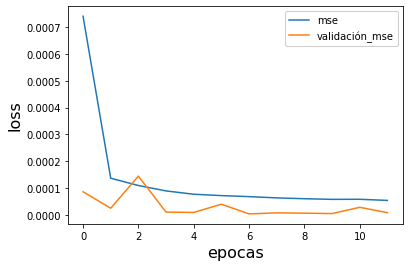

In [16]:
# plot metrics
#plt.figure(figsize=[8,8])
plt.plot(History.history['mean_squared_error'], label='mse')
plt.plot(History.history['val_mean_squared_error'], label= 'validación_mse')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

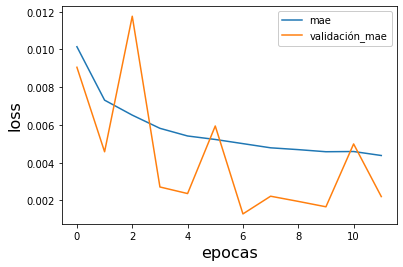

In [17]:
plt.plot(History.history['mean_absolute_error'], label='mae')
plt.plot(History.history['val_mean_absolute_error'], label= 'validación_mae')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [0]:
#History.history['mean_absolute_percentage_error']

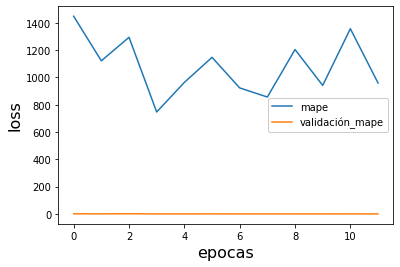

In [19]:
plt.plot(History.history['mean_absolute_percentage_error'], label= 'mape')
plt.plot(History.history['val_mean_absolute_percentage_error'], label= 'validación_mape')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [20]:
# predicciones de los valores de prueba
prediccion_test = model.predict(testX)
prediccion_test = scaler.inverse_transform(prediccion_test)
#actuals = test_y
valor_real_test = scaler.inverse_transform([testY])
valor_real_test= valor_real_test.reshape(len(prediccion_test),1)
#prediccion de los valores de entrenamiento
aprendido=model.predict(trainX)
aprendido_train=scaler.inverse_transform(aprendido)
reales_train=scaler.inverse_transform([trainY])
reales_train=scaler.inverse_transform([trainY])
reales_train=reales_train.reshape(len(aprendido),1)
###################################################
mse_aprendido=mean_squared_error(reales_train,aprendido_train)
mse_test=mean_squared_error(valor_real_test,prediccion_test)
print('Train Mean square Error:', mse_aprendido)
print('Test Mean square Error:', mse_test)
#######################################################
rmse_train=math.sqrt(mse_aprendido)
rmse_test=math.sqrt(mse_test)
print('Train Root Mean Squared Error:', rmse_train)
print('Test Root Mean Squared Error:', rmse_test)


Train Mean square Error: 0.07840713952114622
Test Mean square Error: 0.11234271326668514
Train Root Mean Squared Error: 0.2800127488546659
Test Root Mean Squared Error: 0.3351756453960895


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
#mape train
mean_absolute_percentage_error(reales_train,aprendido_train)

1.699776019911072

In [23]:
#mape test
mean_absolute_percentage_error(valor_real_test,prediccion_test)

1.4634465825224257

In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [25]:
smape(reales_train,aprendido_train)

1.6851949510927686

In [26]:
smape(valor_real_test,prediccion_test)

1.4516937663754848

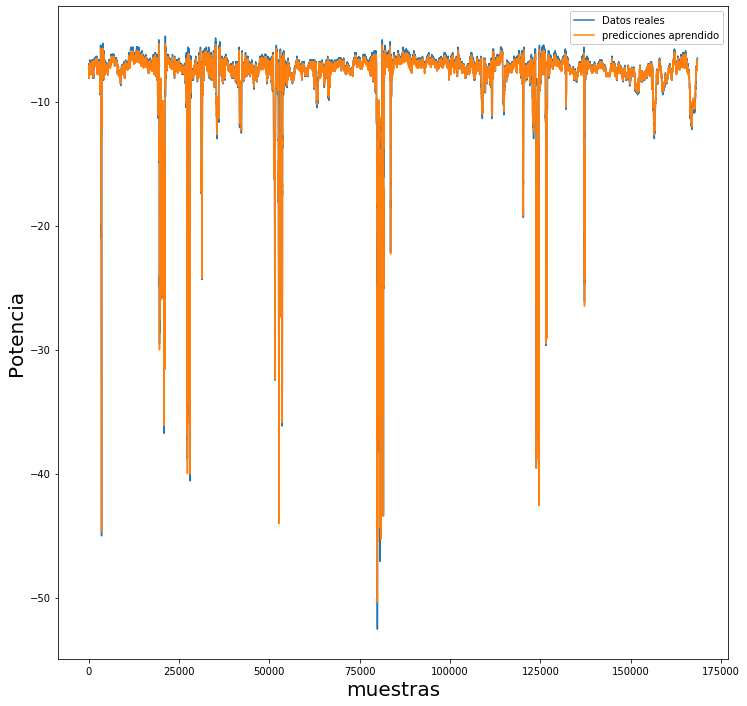

In [27]:
# plot entrenamiento
plt.figure(figsize=[12,12])
plt.plot(reales_train, label='Datos reales')
plt.plot(aprendido_train, label= 'predicciones aprendido')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

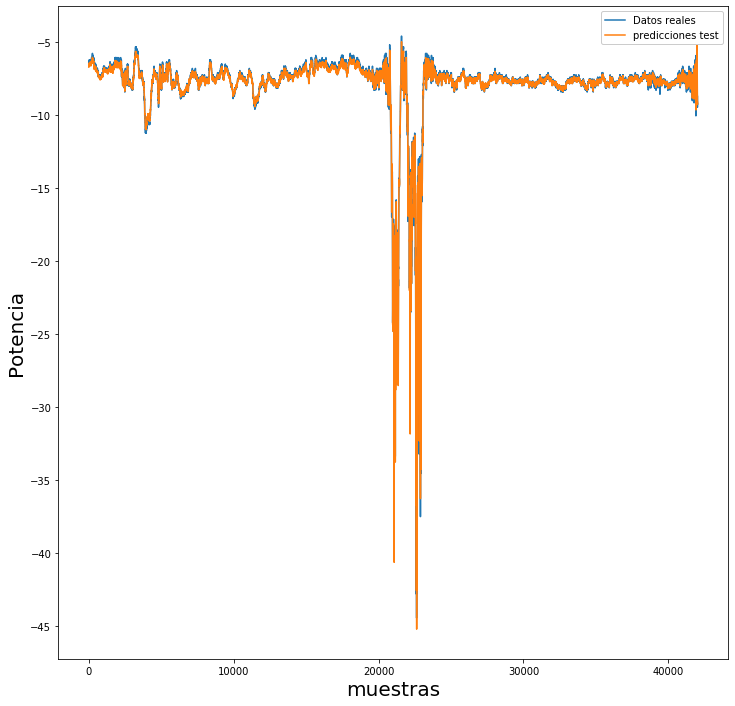

In [28]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test, label='Datos reales')
plt.plot(prediccion_test , label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

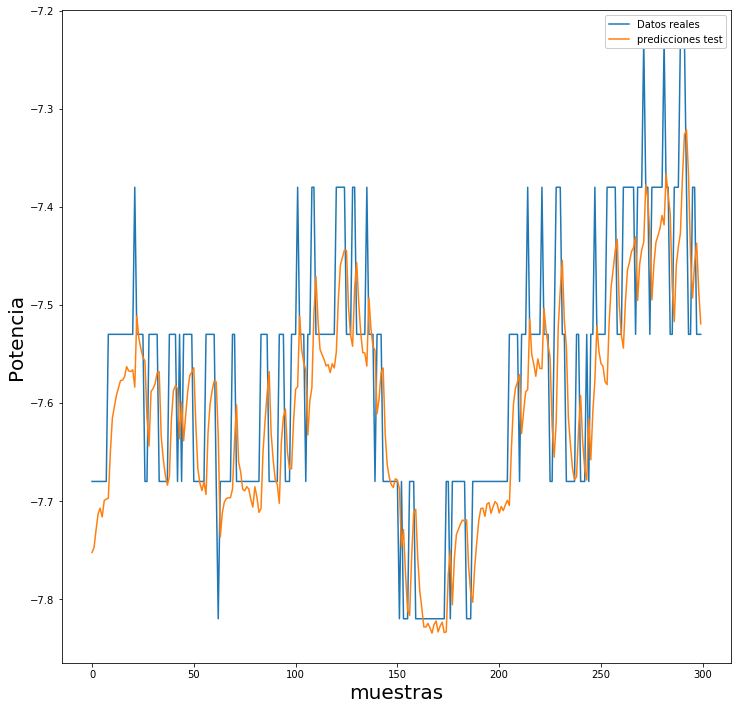

In [29]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test[33200:33500], label='Datos reales')
plt.plot(prediccion_test[33200:33500], label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

In [30]:
acc = abs(prediccion_test-valor_real_test)
porc_error = (acc / abs(valor_real_test)) * 100
mostrar = valor_real_test, prediccion_test, acc, porc_error
Tabla_arr = np.array(mostrar)
Tabla = np.transpose(Tabla_arr)
Tabla=Tabla.reshape(len(acc), -1)
Tabla_df = pd.DataFrame(Tabla, columns=['Datos predichos','Datos reales','Error','Error porcentual'])
Tabla_df

,Datos predichos,Datos reales,Error,Error porcentual
0,-6.49,-6.701807,0.211807,3.263590
1,-6.49,-6.667279,0.177279,2.731568
2,-6.49,-6.658704,0.168704,2.599442
3,-6.49,-6.655953,0.165953,2.557063
4,-6.49,-6.651027,0.161027,2.481151
...,...,...,...,...
42011,-9.30,-9.251939,0.048061,0.516787
42012,-9.30,-9.259130,0.040870,0.439467
42013,-9.15,-9.264607,0.114607,1.252540
42014,-9.00,-9.210242,0.210242,2.336025


In [0]:
import seaborn as sns

In [0]:
aprendido_red=aprendido_train[:,0]
rial=reales_train[:,0]
testing=valor_real_test[:,0]
prediccion=prediccion_test[:,0]

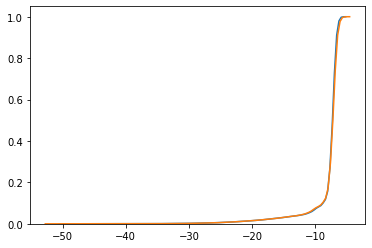

In [33]:
sns.kdeplot(aprendido_red, cumulative=True)
sns.kdeplot(rial, cumulative=True)

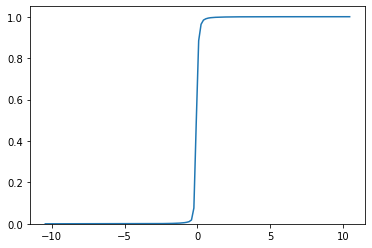

In [34]:
err_apre=aprendido_train-reales_train
err_2=err_apre[:,0]
sns.kdeplot(err_2, cumulative=True)

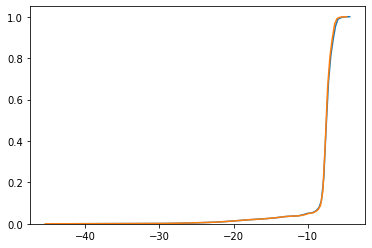

In [35]:
sns.kdeplot(testing, cumulative=True)
sns.kdeplot(prediccion, cumulative=True)

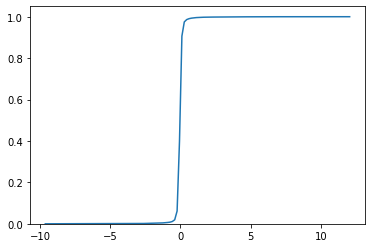

In [36]:
err=prediccion_test-valor_real_test
err_1=err[:,0]
sns.kdeplot(err_1, cumulative=True)

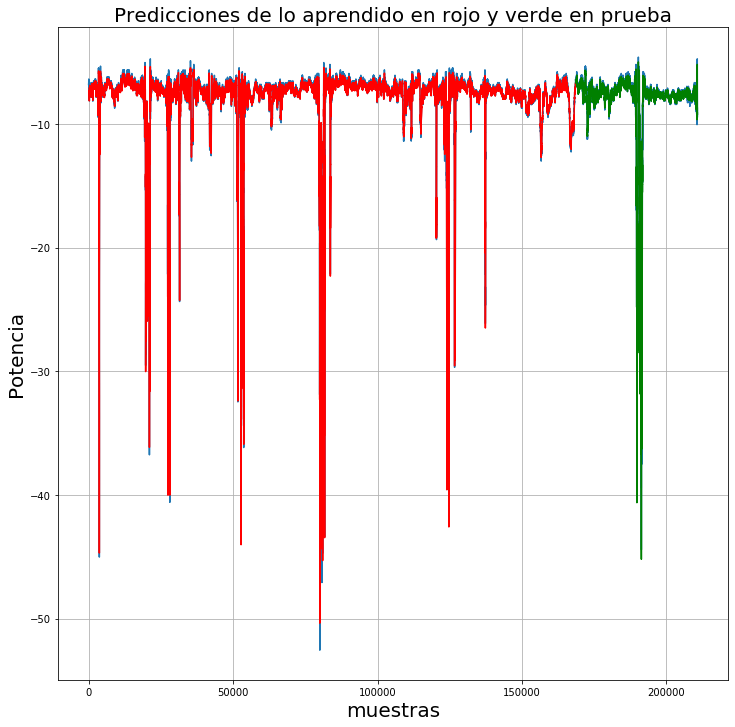

In [37]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(POT2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(aprendido_train)+look_back, :] = aprendido_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(POT2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(aprendido_train)+(look_back*2)+1:len(POT2)-1, :] = prediccion_test
# plot baseline and predictions
plt.figure(figsize=[12,12])
plt.plot((POT))
plt.plot(trainPredictPlot, color="red", )
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.plot(testPredictPlot, color="green")
plt.title("Predicciones de lo aprendido en rojo y verde en prueba", fontsize = 20)
plt.grid()
plt.show()

In [0]:
adqw=trainPredictPlot+testPredictPlot